In [1]:
import torch
from tqdm import tqdm
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../')
from data.FloorPlanLoader import *
from model.VQAE import VQAE
from utils import *
from train import *

#Reproducability Checks:
random.seed(0) #Python
torch.manual_seed(0) #Torch
np.random.seed(0) #NumPy

### Hyperparameters

In [2]:
#Hyperparameter
batch_size = 128
n_hiddens = 32
n_residual_hiddens = 32
n_residual_layers = 1
embedding_dim = 64
n_embeddings = 218
beta = .25
lr = 3e-3
noise=False
noise_weight=0.05
img_channel=3

### Load Dataset

In [34]:
#Load Dataset
floor = FloorPlanDataset(multi_scale=True, root='../data/data_root/data00/', preprocess=True)
data_variance = floor.var
val_len = int(len(floor)/10)
train_set, val_set = torch.utils.data.random_split(floor, [len(floor)-val_len, val_len])
# data_variance = get_data_variance(train_set)

print(f"data shape: {floor[0]['image_tensor'].shape}, dataset size: {len(floor)}, data variance: {data_variance}")

train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle = True)
validation_loader = torch.utils.data.DataLoader(val_set, batch_size = batch_size, shuffle = False)

data shape: torch.Size([3, 112, 112]), dataset size: 23041, data variance: 0.045053429901599884


In [35]:
print(f"data shape: {floor[0]['image_tensor'].shape}, dataset size: {len(floor)}, data variance: {data_variance}")

data shape: torch.Size([3, 112, 112]), dataset size: 23041, data variance: 0.045053429901599884


In [36]:
floor[0]

{'image_tensor': tensor([[[0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
          ...,
          [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000]],
 
         [[0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
          ...,
          [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000]],
 
         [[0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
          [0.5000, 0.500

### Load Best or Train

In [23]:
vqvae = VQAE(n_hiddens, n_residual_hiddens, n_residual_layers,
                n_embeddings, embedding_dim, 
                beta, img_channel).to(device)
optimizer = torch.optim.Adam(vqvae.parameters(), lr=lr, amsgrad=False)
train_res_recon_error = []
test_res_recon_error = []
start_epoch = 0
end_epoch = 300
best_loss = 2

##### load best checkpoint

In [15]:
vqvae.load_state_dict(torch.load("../checkpoint/140-vqae-0.14986537524632043.pt"))
optimizer.load_state_dict(torch.load("../checkpoint/140-adam-0.14986537524632043.pt"))

with open("../checkpoint/140-vqae_train-0.14986537524632043.json") as json_file:
    train_res_recon_error = json.load(json_file)
with open("../checkpoint/140-vqae_test-0.14986537524632043.json") as json_file:
    test_res_recon_error = json.load(json_file)
    
start_epoch = 140
end_epoch = 300
best_loss = 0.14986537524632043

FileNotFoundError: [Errno 2] No such file or directory: '../checkpoint/140-vqae-0.14986537524632043.pt'

##### train

In [26]:
for epoch in range(start_epoch+1, end_epoch+1):
    with tqdm(train_loader, unit="batch") as tepoch:
        vqvae.train()
        for data in tepoch:
            data_no_noise = data.to(device)
            optimizer.zero_grad()

            if noise:
                data = add_noise(data_no_noise, noise_weight=noise_weight)
            else:
                data = data_no_noise
            vq_loss, data_recon, perplexity = vqvae(data_no_noise)
            recon_error = F.mse_loss(data_recon, data_no_noise) / data_variance
            loss = recon_error + vq_loss
            loss.backward()

            optimizer.step()
            tepoch.set_postfix(loss=float(loss.detach().cpu()))
            train_res_recon_error.append(recon_error.item())

    avg_loss = 0
    vqvae.eval()
    with torch.no_grad():
        for data in validation_loader:
            data = data.to(device)

            vq_loss, data_recon, perplexity = vqvae(data)
            recon_error = F.mse_loss(data_recon, data) / data_variance
            loss = recon_error.item() * batch_size

            avg_loss += loss / val_len
            test_res_recon_error.append(loss)
            
    if epoch%5==0 and avg_loss<best_loss:
        best_loss = avg_loss
        best_epoch = epoch
        torch.save(vqvae.state_dict(), f"../checkpoint/{best_epoch}-vqae-{best_loss}.pt")
        torch.save(optimizer.state_dict(), f"../checkpoint/{best_epoch}-adam-{best_loss}.pt")
        with open(f"../checkpoint/{best_epoch}-vqae_train-{best_loss}.json", 'w', encoding ='utf8') as json_file:
            json.dump(train_res_recon_error, json_file, ensure_ascii = False)
        with open(f"../checkpoint/{best_epoch}-vqae_test-{best_loss}.json", 'w', encoding ='utf8') as json_file:
            json.dump(test_res_recon_error, json_file, ensure_ascii = False)

    print(f'Validation Loss: {avg_loss}')

100%|█████████████████████████████████████████████████████████████████| 163/163 [00:41<00:00,  3.93batch/s, loss=0.114]


Validation Loss: 0.11833047990997632


100%|█████████████████████████████████████████████████████████████████| 163/163 [00:43<00:00,  3.76batch/s, loss=0.172]


Validation Loss: 0.12563321905003652


100%|█████████████████████████████████████████████████████████████████| 163/163 [00:43<00:00,  3.72batch/s, loss=0.206]


Validation Loss: 0.19570464971992702


100%|████████████████████████████████████████████████████████████████| 163/163 [00:44<00:00,  3.70batch/s, loss=0.0977]


Validation Loss: 0.10112992177406947


100%|████████████████████████████████████████████████████████████████| 163/163 [00:44<00:00,  3.69batch/s, loss=0.0796]


Validation Loss: 0.08586601540446281


100%|██████████████████████████████████████████████████████████████████| 163/163 [00:44<00:00,  3.68batch/s, loss=1.12]


Validation Loss: 0.2501274968187014


100%|████████████████████████████████████████████████████████████████| 163/163 [00:44<00:00,  3.67batch/s, loss=0.0855]


Validation Loss: 0.08819611577524078


100%|████████████████████████████████████████████████████████████████| 163/163 [00:44<00:00,  3.67batch/s, loss=0.0784]


Validation Loss: 0.0871013928618696


100%|██████████████████████████████████████████████████████████████████| 163/163 [00:44<00:00,  3.68batch/s, loss=0.23]


Validation Loss: 0.24444028652376598


100%|████████████████████████████████████████████████████████████████| 163/163 [00:44<00:00,  3.67batch/s, loss=0.0642]


Validation Loss: 0.08221779887874921


100%|█████████████████████████████████████████████████████████████████| 163/163 [00:44<00:00,  3.67batch/s, loss=0.198]


Validation Loss: 0.08350955280992721


100%|███████████████████████████████████████████████████████████████████| 163/163 [00:44<00:00,  3.68batch/s, loss=0.1]


Validation Loss: 0.07482351362705231


100%|████████████████████████████████████████████████████████████████| 163/163 [00:44<00:00,  3.69batch/s, loss=0.0705]


Validation Loss: 0.07369491913252406


100%|█████████████████████████████████████████████████████████████████| 163/163 [00:44<00:00,  3.67batch/s, loss=0.105]


Validation Loss: 0.08015444171097544


100%|████████████████████████████████████████████████████████████████| 163/163 [00:44<00:00,  3.67batch/s, loss=0.0767]


Validation Loss: 0.07138213473889564


100%|████████████████████████████████████████████████████████████████| 163/163 [00:44<00:00,  3.68batch/s, loss=0.0508]


Validation Loss: 0.069714295781321


100%|████████████████████████████████████████████████████████████████| 163/163 [00:44<00:00,  3.68batch/s, loss=0.0524]


Validation Loss: 0.06940865971975857


100%|█████████████████████████████████████████████████████████████████| 163/163 [00:44<00:00,  3.68batch/s, loss=0.117]


Validation Loss: 0.06354855766726863


100%|█████████████████████████████████████████████████████████████████| 163/163 [00:44<00:00,  3.67batch/s, loss=0.119]


Validation Loss: 0.08259722507662243


100%|████████████████████████████████████████████████████████████████| 163/163 [00:44<00:00,  3.67batch/s, loss=0.0913]


Validation Loss: 0.06026487756106589


100%|█████████████████████████████████████████████████████████████████| 163/163 [00:44<00:00,  3.66batch/s, loss=0.113]


Validation Loss: 0.06035682848758167


100%|████████████████████████████████████████████████████████████████| 163/163 [00:44<00:00,  3.68batch/s, loss=0.0968]


Validation Loss: 0.07371561270621087


100%|████████████████████████████████████████████████████████████████| 163/163 [00:44<00:00,  3.65batch/s, loss=0.0788]


Validation Loss: 0.05621567451291615


100%|████████████████████████████████████████████████████████████████| 163/163 [00:44<00:00,  3.65batch/s, loss=0.0484]


Validation Loss: 0.051780111466844886


100%|█████████████████████████████████████████████████████████████████| 163/163 [00:44<00:00,  3.67batch/s, loss=0.106]


Validation Loss: 0.049443581451972335


100%|██████████████████████████████████████████████████████████████████| 163/163 [00:44<00:00,  3.67batch/s, loss=0.11]


Validation Loss: 0.05283904344671303


100%|████████████████████████████████████████████████████████████████| 163/163 [00:44<00:00,  3.68batch/s, loss=0.0489]


Validation Loss: 0.05183773073885176


100%|████████████████████████████████████████████████████████████████| 163/163 [00:44<00:00,  3.68batch/s, loss=0.0609]


Validation Loss: 0.0457011339151197


100%|████████████████████████████████████████████████████████████████| 163/163 [00:44<00:00,  3.67batch/s, loss=0.0521]


Validation Loss: 0.03928266382879681


100%|████████████████████████████████████████████████████████████████| 163/163 [00:44<00:00,  3.67batch/s, loss=0.0623]


Validation Loss: 0.040114057146840625


100%|█████████████████████████████████████████████████████████████████| 163/163 [00:44<00:00,  3.65batch/s, loss=0.129]


Validation Loss: 0.05222054426040914


100%|█████████████████████████████████████████████████████████████████| 163/163 [00:44<00:00,  3.66batch/s, loss=0.122]


Validation Loss: 0.05922724451455805


100%|████████████████████████████████████████████████████████████████| 163/163 [00:44<00:00,  3.65batch/s, loss=0.0598]


Validation Loss: 0.03887799030376806


100%|█████████████████████████████████████████████████████████████████| 163/163 [00:44<00:00,  3.65batch/s, loss=0.126]


Validation Loss: 0.04218188921610514


100%|████████████████████████████████████████████████████████████████| 163/163 [00:44<00:00,  3.66batch/s, loss=0.0569]


Validation Loss: 0.03588031832542684


100%|█████████████████████████████████████████████████████████████████| 163/163 [00:44<00:00,  3.66batch/s, loss=0.071]


Validation Loss: 0.04398942883643839


100%|████████████████████████████████████████████████████████████████| 163/163 [00:44<00:00,  3.67batch/s, loss=0.0736]


Validation Loss: 0.033701431627074875


100%|████████████████████████████████████████████████████████████████| 163/163 [00:44<00:00,  3.67batch/s, loss=0.0623]


Validation Loss: 0.0334522005998426


100%|████████████████████████████████████████████████████████████████| 163/163 [00:44<00:00,  3.66batch/s, loss=0.0427]


Validation Loss: 0.03282472687876886


100%|████████████████████████████████████████████████████████████████| 163/163 [00:45<00:00,  3.60batch/s, loss=0.0811]


Validation Loss: 0.06219539273944167


100%|████████████████████████████████████████████████████████████████| 163/163 [00:44<00:00,  3.66batch/s, loss=0.0382]


Validation Loss: 0.029604731851981748


100%|████████████████████████████████████████████████████████████████| 163/163 [00:44<00:00,  3.65batch/s, loss=0.0686]


Validation Loss: 0.06022355229490334


100%|█████████████████████████████████████████████████████████████████| 163/163 [00:44<00:00,  3.67batch/s, loss=0.107]


Validation Loss: 0.05573337876962291


100%|████████████████████████████████████████████████████████████████| 163/163 [00:44<00:00,  3.68batch/s, loss=0.0445]


Validation Loss: 1.3741951982180276


100%|█████████████████████████████████████████████████████████████████| 163/163 [00:44<00:00,  3.67batch/s, loss=0.063]


Validation Loss: 0.03231103945937422


100%|████████████████████████████████████████████████████████████████| 163/163 [00:44<00:00,  3.66batch/s, loss=0.0669]


Validation Loss: 0.029527426490353215


100%|████████████████████████████████████████████████████████████████| 163/163 [00:44<00:00,  3.67batch/s, loss=0.0931]


Validation Loss: 0.032742190071278154


100%|████████████████████████████████████████████████████████████████| 163/163 [00:44<00:00,  3.68batch/s, loss=0.0423]


Validation Loss: 0.026193704766531784


100%|█████████████████████████████████████████████████████████████████| 163/163 [00:44<00:00,  3.68batch/s, loss=0.125]


Validation Loss: 0.04517118425832854


100%|█████████████████████████████████████████████████████████████████| 163/163 [00:44<00:00,  3.68batch/s, loss=0.101]


Validation Loss: 0.03966704507668814


100%|█████████████████████████████████████████████████████████████████| 163/163 [00:44<00:00,  3.67batch/s, loss=0.463]


Validation Loss: 0.852611823214425


100%|█████████████████████████████████████████████████████████████████| 163/163 [00:44<00:00,  3.67batch/s, loss=0.484]


Validation Loss: 0.5839853054947323


100%|█████████████████████████████████████████████████████████████████| 163/163 [00:44<00:00,  3.67batch/s, loss=0.328]


Validation Loss: 0.5945168303118811


100%|█████████████████████████████████████████████████████████████████| 163/163 [00:44<00:00,  3.67batch/s, loss=0.297]


Validation Loss: 0.602749271525277


100%|█████████████████████████████████████████████████████████████████| 163/163 [00:44<00:00,  3.68batch/s, loss=0.274]


Validation Loss: 0.5870949261718327


100%|█████████████████████████████████████████████████████████████████| 163/163 [00:44<00:00,  3.68batch/s, loss=0.256]


Validation Loss: 0.6368846032354567


100%|█████████████████████████████████████████████████████████████████| 163/163 [00:44<00:00,  3.68batch/s, loss=0.319]


Validation Loss: 0.5423444377051458


100%|█████████████████████████████████████████████████████████████████| 163/163 [00:44<00:00,  3.67batch/s, loss=0.303]


Validation Loss: 0.45596227712101406


100%|█████████████████████████████████████████████████████████████████| 163/163 [00:44<00:00,  3.68batch/s, loss=0.291]


Validation Loss: 0.444170034594006


100%|█████████████████████████████████████████████████████████████████| 163/163 [00:45<00:00,  3.55batch/s, loss=0.382]


Validation Loss: 0.480114233162668


100%|█████████████████████████████████████████████████████████████████| 163/163 [00:44<00:00,  3.67batch/s, loss=0.364]


Validation Loss: 0.5537911156813303


100%|██████████████████████████████████████████████████████████████████| 163/163 [00:44<00:00,  3.68batch/s, loss=0.32]


Validation Loss: 0.44398616751035047


100%|█████████████████████████████████████████████████████████████████| 163/163 [00:44<00:00,  3.68batch/s, loss=0.443]


Validation Loss: 0.44578510357273954


100%|██████████████████████████████████████████████████████████████████| 163/163 [00:44<00:00,  3.68batch/s, loss=1.14]


Validation Loss: 3.1508216593000626


100%|█████████████████████████████████████████████████████████████████| 163/163 [00:44<00:00,  3.67batch/s, loss=0.771]


Validation Loss: 0.3886389897929299


100%|██████████████████████████████████████████████████████████████████| 163/163 [00:44<00:00,  3.67batch/s, loss=1.28]


Validation Loss: 0.4012903471787771


100%|█████████████████████████████████████████████████████████████████| 163/163 [00:44<00:00,  3.67batch/s, loss=0.381]


Validation Loss: 0.40133143299155766


100%|█████████████████████████████████████████████████████████████████| 163/163 [02:33<00:00,  1.06batch/s, loss=0.237]


Validation Loss: 0.40665944748454624


100%|█████████████████████████████████████████████████████████████████| 163/163 [02:22<00:00,  1.14batch/s, loss=0.298]


Validation Loss: 0.4361487577358881


100%|█████████████████████████████████████████████████████████████████| 163/163 [01:54<00:00,  1.42batch/s, loss=0.215]


Validation Loss: 0.4352208508385553


100%|█████████████████████████████████████████████████████████████████| 163/163 [00:40<00:00,  4.05batch/s, loss=0.218]


Validation Loss: 0.35174374447928536


100%|█████████████████████████████████████████████████████████████████| 163/163 [00:41<00:00,  3.92batch/s, loss=0.241]


Validation Loss: 0.39331139789687264


100%|█████████████████████████████████████████████████████████████████| 163/163 [00:42<00:00,  3.80batch/s, loss=0.429]


Validation Loss: 0.3663749959733751


100%|█████████████████████████████████████████████████████████████████| 163/163 [00:43<00:00,  3.73batch/s, loss=0.349]


Validation Loss: 0.37830322318606907


100%|█████████████████████████████████████████████████████████████████| 163/163 [00:44<00:00,  3.70batch/s, loss=0.284]


Validation Loss: 0.3557321180899938


100%|█████████████████████████████████████████████████████████████████| 163/163 [00:44<00:00,  3.68batch/s, loss=0.261]


Validation Loss: 0.34888958930969244


100%|█████████████████████████████████████████████████████████████████| 163/163 [00:44<00:00,  3.68batch/s, loss=0.235]


Validation Loss: 0.33856007622347933


100%|█████████████████████████████████████████████████████████████████| 163/163 [00:44<00:00,  3.68batch/s, loss=0.546]


Validation Loss: 0.3544471379783419


100%|█████████████████████████████████████████████████████████████████| 163/163 [00:44<00:00,  3.67batch/s, loss=0.358]


Validation Loss: 0.30421434673998093


100%|█████████████████████████████████████████████████████████████████| 163/163 [00:44<00:00,  3.66batch/s, loss=0.194]


Validation Loss: 0.29666267666551793


100%|█████████████████████████████████████████████████████████████████| 163/163 [00:44<00:00,  3.66batch/s, loss=0.382]


Validation Loss: 0.8501859075493283


100%|█████████████████████████████████████████████████████████████████| 163/163 [00:44<00:00,  3.66batch/s, loss=0.216]


Validation Loss: 0.2745678921540578


100%|█████████████████████████████████████████████████████████████████| 163/163 [00:44<00:00,  3.68batch/s, loss=0.419]


Validation Loss: 0.277072721057468


100%|██████████████████████████████████████████████████████████████████| 163/163 [00:44<00:00,  3.67batch/s, loss=0.23]


Validation Loss: 0.27237817148367566


100%|█████████████████████████████████████████████████████████████████| 163/163 [00:44<00:00,  3.66batch/s, loss=0.282]


Validation Loss: 0.27143896288341945


100%|█████████████████████████████████████████████████████████████████| 163/163 [00:44<00:00,  3.67batch/s, loss=0.344]


Validation Loss: 0.28451038897037506


100%|█████████████████████████████████████████████████████████████████| 163/163 [00:44<00:00,  3.67batch/s, loss=0.464]


Validation Loss: 0.26861963255537885


100%|███████████████████████████████████████████████████████████████████| 163/163 [00:44<00:00,  3.65batch/s, loss=0.2]


Validation Loss: 0.2579532994164361


100%|█████████████████████████████████████████████████████████████████| 163/163 [00:44<00:00,  3.67batch/s, loss=0.373]


Validation Loss: 0.2621440986792246


100%|█████████████████████████████████████████████████████████████████| 163/163 [00:44<00:00,  3.67batch/s, loss=0.301]


Validation Loss: 0.25315922333134544


100%|██████████████████████████████████████████████████████████████████| 163/163 [00:44<00:00,  3.66batch/s, loss=0.41]


Validation Loss: 0.42209760182433664


100%|█████████████████████████████████████████████████████████████████| 163/163 [00:44<00:00,  3.66batch/s, loss=0.256]


Validation Loss: 0.2505999306837718


100%|█████████████████████████████████████████████████████████████████| 163/163 [00:44<00:00,  3.68batch/s, loss=0.229]


Validation Loss: 0.38736425340175623


100%|█████████████████████████████████████████████████████████████████| 163/163 [00:44<00:00,  3.67batch/s, loss=0.282]


Validation Loss: 0.26915392776330305


100%|█████████████████████████████████████████████████████████████████| 163/163 [00:44<00:00,  3.67batch/s, loss=0.191]


Validation Loss: 0.2684810608625412


100%|█████████████████████████████████████████████████████████████████| 163/163 [00:44<00:00,  3.67batch/s, loss=0.212]


Validation Loss: 0.25380339556270176


100%|█████████████████████████████████████████████████████████████████| 163/163 [00:44<00:00,  3.67batch/s, loss=0.196]


Validation Loss: 0.13789798567692438


100%|█████████████████████████████████████████████████████████████████| 163/163 [00:44<00:00,  3.67batch/s, loss=0.298]


Validation Loss: 0.18539420598083073


100%|█████████████████████████████████████████████████████████████████| 163/163 [00:44<00:00,  3.67batch/s, loss=0.172]


Validation Loss: 0.15728708936108482


100%|██████████████████████████████████████████████████████████████████| 163/163 [00:44<00:00,  3.67batch/s, loss=0.12]


Validation Loss: 0.1312469844188955


100%|█████████████████████████████████████████████████████████████████| 163/163 [00:44<00:00,  3.67batch/s, loss=0.149]


Validation Loss: 0.16968902862734264


100%|█████████████████████████████████████████████████████████████████| 163/163 [00:44<00:00,  3.65batch/s, loss=0.195]


Validation Loss: 0.1384373323784934


100%|█████████████████████████████████████████████████████████████████| 163/163 [00:44<00:00,  3.65batch/s, loss=0.122]


Validation Loss: 0.12359747911492981


100%|█████████████████████████████████████████████████████████████████| 163/163 [00:44<00:00,  3.66batch/s, loss=0.234]


Validation Loss: 0.20840995013713837


100%|█████████████████████████████████████████████████████████████████| 163/163 [00:44<00:00,  3.66batch/s, loss=0.151]


Validation Loss: 0.11593046701616712


100%|█████████████████████████████████████████████████████████████████| 163/163 [00:44<00:00,  3.66batch/s, loss=0.757]


Validation Loss: 2.459843926959568


100%|█████████████████████████████████████████████████████████████████| 163/163 [00:44<00:00,  3.66batch/s, loss=0.193]


Validation Loss: 0.14111913492282233


100%|█████████████████████████████████████████████████████████████████| 163/163 [00:44<00:00,  3.66batch/s, loss=0.209]


Validation Loss: 0.13260890212323934


100%|█████████████████████████████████████████████████████████████████| 163/163 [00:44<00:00,  3.66batch/s, loss=0.131]


Validation Loss: 0.12294325025545223


100%|█████████████████████████████████████████████████████████████████| 163/163 [00:44<00:00,  3.66batch/s, loss=0.185]


Validation Loss: 0.12278147455718781


100%|█████████████████████████████████████████████████████████████████| 163/163 [00:44<00:00,  3.66batch/s, loss=0.186]


Validation Loss: 0.11711190268397331


100%|█████████████████████████████████████████████████████████████████| 163/163 [00:44<00:00,  3.67batch/s, loss=0.116]


Validation Loss: 0.11292057525780466


100%|█████████████████████████████████████████████████████████████████| 163/163 [00:44<00:00,  3.67batch/s, loss=0.183]


Validation Loss: 0.12622988265421656


100%|█████████████████████████████████████████████████████████████████| 163/163 [00:44<00:00,  3.66batch/s, loss=0.119]


Validation Loss: 0.14802839938137266


100%|█████████████████████████████████████████████████████████████████| 163/163 [00:44<00:00,  3.66batch/s, loss=0.127]


Validation Loss: 0.7660564151075152


100%|█████████████████████████████████████████████████████████████████| 163/163 [00:44<00:00,  3.67batch/s, loss=0.107]


Validation Loss: 0.10202327039506698


100%|█████████████████████████████████████████████████████████████████| 163/163 [00:44<00:00,  3.67batch/s, loss=0.238]


Validation Loss: 0.259007479581568


100%|█████████████████████████████████████████████████████████████████| 163/163 [00:44<00:00,  3.67batch/s, loss=0.207]


Validation Loss: 0.11410714189211527


100%|█████████████████████████████████████████████████████████████████| 163/163 [00:44<00:00,  3.67batch/s, loss=0.575]


Validation Loss: 0.21155028127961686


100%|█████████████████████████████████████████████████████████████████| 163/163 [00:44<00:00,  3.67batch/s, loss=0.196]


Validation Loss: 0.11997545717491044


100%|█████████████████████████████████████████████████████████████████| 163/163 [00:44<00:00,  3.67batch/s, loss=0.118]


Validation Loss: 0.10890545571843784


100%|█████████████████████████████████████████████████████████████████| 163/163 [00:44<00:00,  3.64batch/s, loss=0.123]


Validation Loss: 0.10526674530572362


 63%|█████████████████████████████████████████                        | 103/163 [00:28<00:16,  3.62batch/s, loss=0.119]


KeyboardInterrupt: 

### Visualization

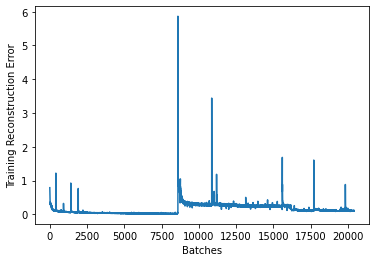

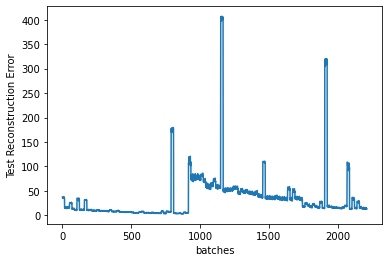

In [27]:
plt.plot(train_res_recon_error[20:])
plt.xlabel('Batches')
plt.ylabel('Training Reconstruction Error')
plt.show()

plt.plot(test_res_recon_error[20:])
plt.xlabel('batches')
plt.ylabel('Test Reconstruction Error')
plt.show()

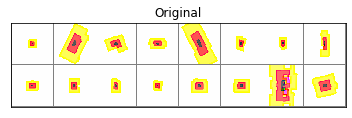

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


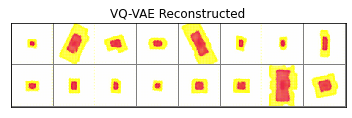

torch.Size([16, 1, 224, 224])


RuntimeError: Sizes of tensors must match except in dimension 2. Got 280 and 224 (The offending index is 0)

In [28]:
vqvae.eval()
temp_loader = torch.utils.data.DataLoader(val_set,batch_size=16,shuffle=True)
(valid_originals) = next(iter(temp_loader))
valid_originals = valid_originals.to(device)

_, valid_recon, _ = vqvae(valid_originals)

def show(img, title):
    npimg = img.numpy()
#     print(img)
    fig = plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    fig.axes.set_title(title)


show(torchvision.utils.make_grid(valid_originals.cpu()) + 0.5, "Original")
plt.show()
show(torchvision.utils.make_grid(valid_recon.cpu().data) + 0.5, "VQ-VAE Reconstructed")
plt.show()

def rescale_img(multi_scaled_channels): #B,C,H,W
    composed_1 = transforms.Compose([
                                    transforms.Resize(224)])
    composed_2 = transforms.Compose([
                                    transforms.Resize(112),
                                    transforms.Pad(56, fill=1.0)])
    composed_3 = transforms.Compose([
                                    transforms.Pad(84, fill=1.0)])
    channel_1 = composed_1(multi_scaled_channels[:,0:1,:,:])
    channel_2 = composed_2(multi_scaled_channels[:,1:2,:,:])
    channel_3 = composed_3(multi_scaled_channels[:,2:3,:,:])
    print(channel_1.shape)
    return torch.cat([channel_1,channel_2,channel_3], dim=1)

valid_originals = rescale_img(valid_originals)
valid_recon = rescale_img(valid_recon)

show(torchvision.utils.make_grid(valid_originals.cpu())+0.5, "Original")
plt.show()
show(torchvision.utils.make_grid(valid_recon.cpu().data) + 0.5, "VQ-VAE Reconstructed")
plt.show()